<a href="https://colab.research.google.com/github/evauclin/Deep_Learning_NLP_Project/blob/main/NLP_Bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projet - Real or Not? NLP with Disaster Tweets

## Project description 

* Competition - https://www.kaggle.com/c/nlp-getting-started

In [ ]:
!pip install -q -U "tensorflow-text==2.8.*"

In [ ]:
!pip install -q tf-models-official==2.7.0

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split

tf.get_logger().setLevel('ERROR')



In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Dataset/NLP/train.csv').drop(['id','keyword','location'],axis=1)
train.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
test = pd.read_csv('/content/drive/MyDrive/Dataset/NLP/test.csv').drop(['id','keyword','location'],axis=1)
test.head()


,text
0,Just happened a terrible car crash
1,"Heard about #earthquake is different cities, s..."
2,"there is a forest fire at spot pond, geese are..."
3,Apocalypse lighting. #Spokane #wildfires
4,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
!python -m spacy download en_core_web_sm -q

     |████████████████████████████████| 12.0 MB 5.3 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [ ]:
import en_core_web_sm
nlp = en_core_web_sm.load()

In [ ]:
from spacy.lang.en.stop_words import STOP_WORDS

In [ ]:
# Remove all non alphanumeric characters except whitespaces
train["text_clean"] = train["text"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" "))
# remove double spaces and spaces at the beginning and end of strings
train["text_clean"] = train["text_clean"].apply(lambda x: x.replace(" +"," ").lower().strip())
# remove stop words and replace everyword with their lemma
train["text_clean"] = train["text_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) & (token.text not in STOP_WORDS)]))
train.head()

,text,target,text_clean
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...
3,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfire evacuation order...
4,Just got sent this photo from Ruby #Alaska as ...,1,send photo ruby alaska smoke wildfire pour school


In [ ]:
X = train.text_clean
X

0                    deed reason earthquake allah forgive
1                   forest fire near la ronge sask canada
2       resident ask shelter place notify officer evac...
3       13000 people receive wildfire evacuation order...
4       send photo ruby alaska smoke wildfire pour school
                              ...                        
7608    giant crane hold bridge collapse nearby home h...
7609    ariaahrary thetawniest control wild fire calif...
7610    m194 0104 utc5 km s volcano hawaii httptcozdto...
7611    police investigate ebike collide car little po...
7612    late home raze northern california wildfire   ...
Name: text_clean, Length: 7613, dtype: object

In [ ]:
y = train.target
y

0       1
1       1
2       1
3       1
4       1
       ..
7608    1
7609    1
7610    1
7611    1
7612    1
Name: target, Length: 7613, dtype: int64

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X,y , test_size=0.33,stratify=y)

In [ ]:
train_data = pd.concat([X_train,y_train],axis = 1)

In [ ]:
val_data = pd.concat([X_val,y_val],axis = 1)

In [ ]:
train = tf.data.Dataset.from_tensor_slices((X_train,y_train)).batch(32)
val = tf.data.Dataset.from_tensor_slices((X_val,y_val)).batch(32)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train = train.cache().prefetch(buffer_size=AUTOTUNE)
val = val.cache().prefetch(buffer_size=AUTOTUNE)


In [ ]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)

In [ ]:
preprocess_model = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [ ]:
bert_preprocess_model = hub.KerasLayer(preprocess_model)


In [ ]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_type_ids', 'input_mask', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
bert_model = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3'

In [ ]:
bert_model = hub.KerasLayer(bert_model)

In [ ]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {bert_model}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: <tensorflow_hub.keras_layer.KerasLayer object at 0x7fea9736b610>
Pooled Outputs Shape:(1, 768)
Pooled Outputs Values:[-0.9216989  -0.39353472 -0.5393176   0.682563    0.43848526 -0.14021198
  0.8774715   0.26043355 -0.63113034 -0.9999658  -0.26320082  0.8510534 ]
Sequence Outputs Shape:(1, 128, 768)
Sequence Outputs Values:[[ 0.19451515  0.25141722  0.19075063 ... -0.24845128  0.38568568
   0.1329099 ]
 [-0.5947862  -0.39420295  0.25245643 ... -0.769468    1.1564158
   0.32475588]
 [ 0.00641477 -0.15766507  0.5461029  ... -0.17451143  0.60289675
   0.42672214]
 ...
 [ 0.21948312 -0.20927148  0.5386829  ...  0.24693674  0.18250933
  -0.4442711 ]
 [ 0.01080263 -0.44553217  0.35990965 ...  0.31722867  0.2356279
  -0.63070595]
 [ 0.29321143 -0.10581905  0.61147535 ...  0.2074582   0.14494652
  -0.35353374]]


In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3', name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4', trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.2)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.7244486]], shape=(1, 1), dtype=float32)


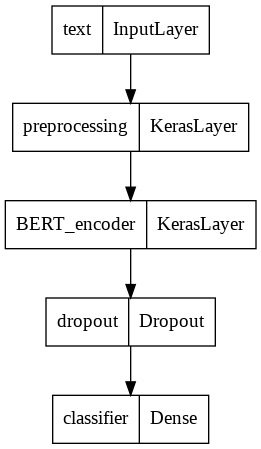

In [ ]:
tf.keras.utils.plot_model(classifier_model)

In [ ]:
classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [ ]:
epochs = 3
steps_per_epoch = tf.data.experimental.cardinality(train).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
print('Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4')
history = classifier_model.fit(x=train,
                               validation_data=val,
                               epochs=epochs
)

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4
Epoch 1/3
160/160 [==============================] - 348s 2s/step - loss: 0.5200 - binary_accuracy: 0.7480 - val_loss: 0.4148 - val_binary_accuracy: 0.8285
Epoch 2/3
160/160 [==============================] - 323s 2s/step - loss: 0.3616 - binary_accuracy: 0.8504 - val_loss: 0.5266 - val_binary_accuracy: 0.8118
Epoch 3/3
160/160 [==============================] - 323s 2s/step - loss: 0.2753 - binary_accuracy: 0.8910 - val_loss: 0.4663 - val_binary_accuracy: 0.8329


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


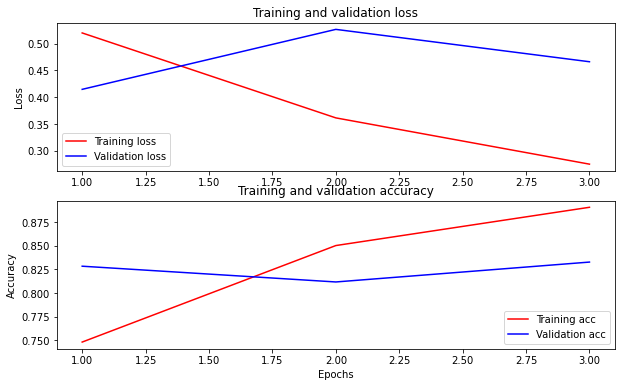

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
val_for_test = list(val_data.iloc[:,0][:1000])
val_for_test

['issue upload death smoochy awakening clip youtube reason bicentennial man pain ass',
 'feeling stage day 22 year friendship body bag mic',
 'lunch stewart amp julian couple hour earlier good finally find happen httptcoanp9g6njfd',
 'hot   c130 specially modify land stadium rescue hostage iran 1980 httptcozy3hpdjnwg prebreak best',
 'come downstairs try look normal possible mom rhiannon scream hungover huh uhmmmm',
 'san jose mercury governor brown allow parole california school bus hijacker   httptcogpcecp9khv',
 'news madhya pradesh train derailment village youth save life httptcofctrawjcyl tilnow ndtv',
 'telnet attack 1241317240 streamyxhomesouthern',
 'mp train derailment village youth save liveshttptcoltyefjdm3a indiatv httptco0la1aw9uud',
 'oh usual mass murder world domination plan coffee s day',
 'responder int bridgeportspeed free saturday detail   httptcodih1tgqhej',
 'eden hazard hockey httpstcorbbnjkoqud',
 'bad look american constitutional system collide new politicû htt

In [ ]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = val_for_test

# reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

# print('Results from the saved model:')
# print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)

Results from the model in memory:
input: issue upload death smoochy awakening clip youtube reason bicentennial man pain ass : score: 0.093876
input: feeling stage day 22 year friendship body bag mic : score: 0.025659
input: lunch stewart amp julian couple hour earlier good finally find happen httptcoanp9g6njfd : score: 0.096524
input: hot   c130 specially modify land stadium rescue hostage iran 1980 httptcozy3hpdjnwg prebreak best : score: 0.992833
input: come downstairs try look normal possible mom rhiannon scream hungover huh uhmmmm : score: 0.038098
input: san jose mercury governor brown allow parole california school bus hijacker   httptcogpcecp9khv : score: 0.982291
input: news madhya pradesh train derailment village youth save life httptcofctrawjcyl tilnow ndtv : score: 0.997142
input: telnet attack 1241317240 streamyxhomesouthern : score: 0.939597
input: mp train derailment village youth save liveshttptcoltyefjdm3a indiatv httptco0la1aw9uud : score: 0.996634
input: oh usual mass

In [ ]:
_tensor = tf.make_tensor_proto(tf.constant(original_results))

In [ ]:
tensor = tf.make_ndarray(_tensor)

In [ ]:
mapping = lambda x : 0 if x<0.5 else 1
vfunc = np.vectorize(mapping)
vfunc(tensor)
array_pred = np.resize(vfunc(tensor),(len(vfunc(tensor))))
array_pred

array([0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0,
       1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1,

In [ ]:
array_true = np.array(val_data.target[:1000])
array_true

array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0,

In [ ]:
precision = precision_score(array_true, array_pred)
print('Precision: %f' % precision)
recall = recall_score(array_true, array_pred)
print('Recall: %f' % recall)
f1 = f1_score(array_true, array_pred)
print('F1 score: %f' % f1)
auc = roc_auc_score(array_true, array_pred)
print('ROC AUC: %f' % auc)



Precision: 0.794582
Recall: 0.822430
F1 score: 0.808266
ROC AUC: 0.831669


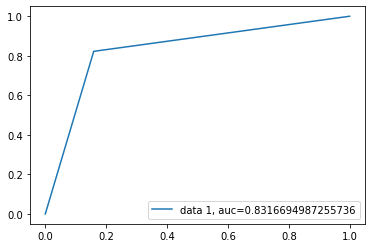

In [ ]:
fpr, tpr, _ = roc_curve(array_true, array_pred)
auc = roc_auc_score(array_true, array_pred)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()